In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Sem 8 files
 data				  __pycache__
 euclidean_distances.json	  Shortest_path_lengths.pkl
'Fri Feb 14 09_06_16 2020.json'   utils.py


In [0]:
!apt-get install -y libspatialindex-c4v5
!pip3.6 install osmnx

import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

from rtree import index
from utils import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 1s (269 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to u

In [0]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [0]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [0]:
f = open("Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/content/drive/My Drive/Sem 8 files/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [0]:
calculate_congestion(G, edges, speed_bands)

In [0]:
# Filter out all bus stop nodes
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']
node_type = nodes['highway']

# nan = 18823

# speed_camera = 2
# motorway_junction = 222
# turning_circle = 79
# crossing = 27
# turning_loop = 26
# mini_roundabout = 6
# traffic signals = 4031

for node, x, y, kind in zip(node_id, xx, yy, node_type):
    if type(kind) == float:
      idx.insert(int(node), (x,y,x,y))

In [0]:
def find_nearest_nodes(nodes, source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = []
    initial = list(idx.intersection((west, south, east, north)))   
    for node in initial:
      x = haversine_distance(nodes, node, source)
      if x <= dist:
        candidate_nodes.append(node)

    return candidate_nodes

In [0]:
def get_length_dict(sources, destinations):
    distances = dict()
  
    for source in sources:        
        for dest in destinations:
            ed = haversine_distance(nodes, source, dest)
            distances[source,dest] = ed/13.8889
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

## Hybrid Algorithm

In [0]:
def hybrid_search(G, x):
    n = len(x)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    final_route = []
    count = 0

    for i in range(n):
        try:            
            travel_time = nx.shortest_path_length(G, source, dest, weight='BPR', method='dijkstra')
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        if travel_time < min_tt:
            min_tt = travel_time
            min_pair = x[i]

            if i < n-1:
                if travel_time < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break
        else:
            if i < n-1:
                if min_tt < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break

    return min_tt, count

## Modified Hybrid Search

In [0]:
def modified_hybrid_search(G, x):
    n = len(x)
    cutoff = math.floor(n/math.exp(1))
    print(cutoff)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    count = 0

    for i in range(n):
        try:            
            travel_time = nx.shortest_path_length(G, source, dest, weight='BPR', method='dijkstra')
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        # have reached cutoff and didnt find optimal yet
        if i > cutoff:
          if travel_time < min_tt:
            min_tt = travel_time
            min_pair = x[i]
            break

          if i < n-1:
            if min_tt < x[i+1][1]:
              break
            else:
              source = x[i+1][0][0]
              dest = x[i+1][0][1]
        else:
          if travel_time < min_tt:
              min_tt = travel_time
              min_pair = x[i]

              if i < n-1:
                  if travel_time < x[i+1][1]:
                      break
                  else:
                      source = x[i+1][0][0]
                      dest = x[i+1][0][1]
              else:
                  break
          else:
              if i < n-1:
                  if min_tt < x[i+1][1]:
                      break
                  else:
                      source = x[i+1][0][0]
                      dest = x[i+1][0][1]
              else:
                  break

    return min_tt, count

### Calculate number of queries and deviation of travel times

In [0]:
def lets_do_this():
    # get 10 random sources
    sources = []
    for i in range(10):
        r = random.randint(0,23210)
        s = nodes['osmid'].values[r]
        sources.append(s)

    # get 10 correspondig random targets
    targets = []
    for i in range(10):
        r = random.randint(0,23210)
        t = nodes['osmid'].values[r]
        targets.append(t)

    mod_hybrid_q = []
    mod_hybrid_t = []
    hybrid_q = []
    hybrid_t = []
  
    for s,t in zip(sources,targets):
        orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
        target_point = nodes[nodes['osmid'] == t].geometry.values[0]
        orig_xy = (orig_point.y, orig_point.x)
        target_xy = (target_point.y, target_point.x)

        # Max distance for walking is 720m (10 min * 1.2 m/s)
        # Find all nodes within 720 m from candidate sources and candidate destinations
        candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
        candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

        if len(candidate_dest) == 0:
          candidate_dest.append(ox.get_nearest_node(G, target_xy))
      
        if len(candidate_source) == 0:
          candidate_source.append(ox.get_nearest_node(G, orig_xy))

        value = len(candidate_dest) * len(candidate_source)
        print(s,t,value)

        euclidean = get_length_dict(candidate_source, candidate_dest)
        value1_t, value1_q = hybrid_search(G, euclidean)
        hybrid_t.append(value1_t)
        hybrid_q.append(value1_q)
        
        value2_t, value2_q = modified_hybrid_search(G, euclidean)
        mod_hybrid_t.append(value2_t)
        mod_hybrid_q.append(value2_q)

    return mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t

In [90]:
mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t = lets_do_this()

206256184 309855456 6174
2271
6065390759 1843186767 4620
1699
5015699389 4592960096 5304
1951
4606173525 1830473115 1323
486
1788428595 229414607 6834
2514
237492645 3054868310 3108
1143
246167375 3412053579 3496
1286
5266984257 410061950 2070
761
2078419410 5936047306 3375
1241
404208394 243713187 2430
893


## Deviation between travel times calculated by hybrid and modified hybrid

In [0]:
deviations = []
for h, mod_h in zip(hybrid_t, mod_hybrid_t):
  stddev = statistics.stdev([h, mod_h])
  deviations.append(stddev)

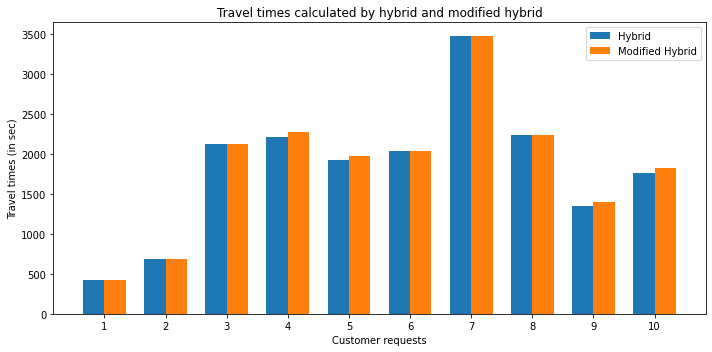

In [92]:
# Plot what hybrid gave and what modified hybrid gave
labels = [x for x in range(1,11)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, hybrid_t, width, label='Hybrid')
rects2 = ax.bar(x + width/2, mod_hybrid_t, width, label='Modified Hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

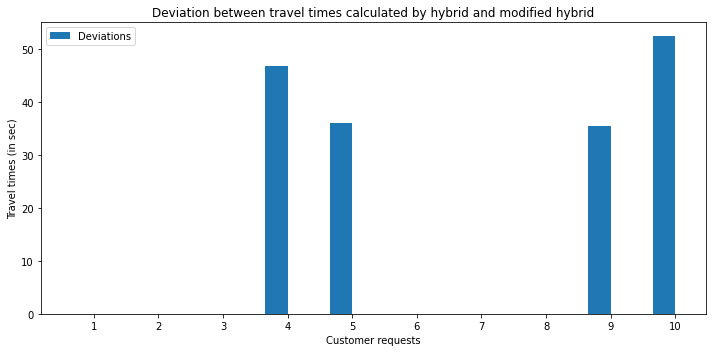

In [93]:
labels = [x for x in range(1,11)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, deviations, width, label='Deviations')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Deviation between travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

In [94]:
print("Average deviation in secs:", statistics.mean(deviations))

Average deviation in secs: 17.05281253598506


## Number of queries

In [95]:
print("Number of queries")
print("Hybrid || Modified Hybrid || Saved %")
for e,h in zip(hybrid_q, mod_hybrid_q):
  saved = ((e-h)/e)*100
  print(e,h,saved)

Number of queries
Hybrid || Modified Hybrid || Saved %
6174 6174 0.0
4620 4620 0.0
5304 5304 0.0
1323 551 58.35222978080121
6834 2699 60.50629206906643
3108 3108 0.0
3496 3496 0.0
2070 2070 0.0
3375 1291 61.748148148148154
2430 1103 54.609053497942384
